In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 

%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

 


In [ ]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import time 
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 
from sklearn.model_selection import TimeSeriesSplit

from math import log
from math import exp
from scipy.stats import boxcox

 
import torch.optim as optim

%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


In [ ]:
device = 'cuda:0'
#device = 'cpu'

In [ ]:
os.getcwd()

'/content'

In [ ]:
INPUT_DIR_PATH = '/content/drive/MyDrive/m5-forecasting-accuracy/'

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df
    

In [ ]:
sell_prices_df,  calendar_df, sales_train_validation_df, submission_df = read_data()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns


In [11]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [14]:
sell_prices_df1 = sell_prices_df['sell_price'].values.reshape(-1,1)

In [ ]:
## EDA

In [ ]:
sales_train_validation_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,item_store_id
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1,HOBBIES_1_001_CA_1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,HOBBIES_1_002_CA_1
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1,HOBBIES_1_003_CA_1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2,HOBBIES_1_004_CA_1
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4,HOBBIES_1_005_CA_1


In [ ]:
sales_train_validation_df.cat_id.unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

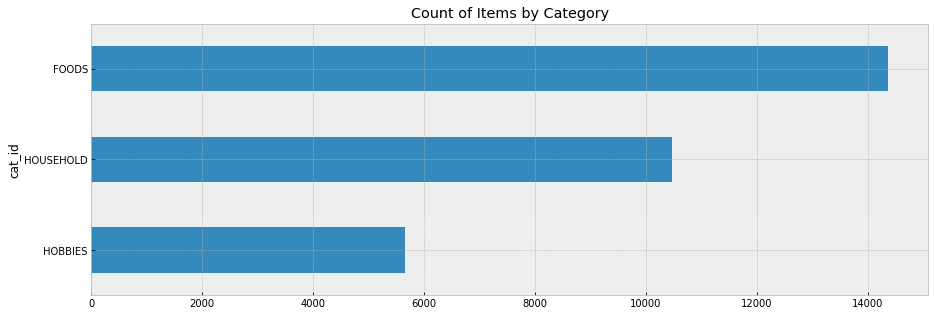

In [ ]:
sales_train_validation_df.groupby('cat_id').count()['id'].sort_values().plot(kind='barh', figsize=(15,5), title='Count of Items by Category')

In [ ]:
d_cols = [d for d in sales_train_validation_df.columns if 'd_' in d ]

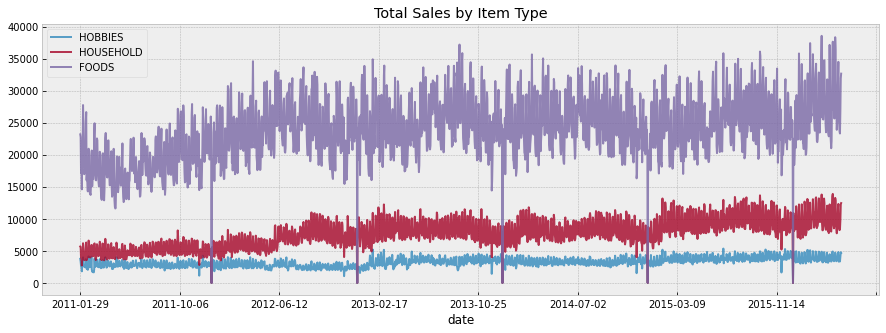

In [ ]:
past_sales = sales_train_validation_df.set_index('id')[d_cols] \
    .T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

for i in sales_train_validation_df['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(sales_train_validation_df['cat_id'].unique())
plt.show()

In [ ]:
sales_train_validation_df.store_id.value_counts().plot(kind='bar', legend=True)

NameError: ignored

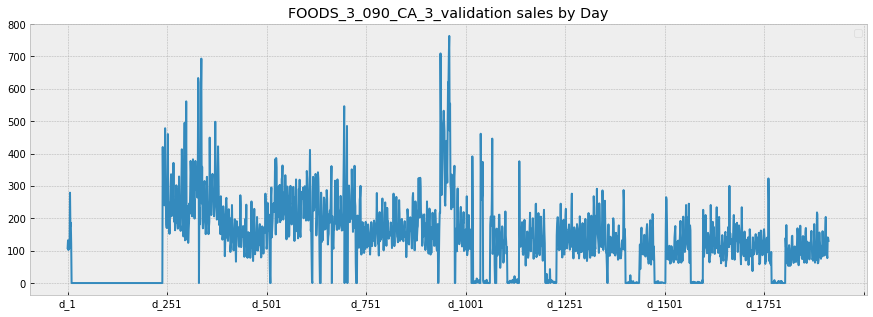

In [ ]:
## Plotting a random item 

sales_train_validation_df.loc[sales_train_validation_df['id']=='FOODS_3_090_CA_3_validation'].set_index('id')[d_cols].T\
.plot(figsize=(15,5), title='FOODS_3_090_CA_3_validation sales by Day')
plt.legend('')
plt.show()

In [ ]:
## Using Calendar dates on our data

In [ ]:
calendar_df[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


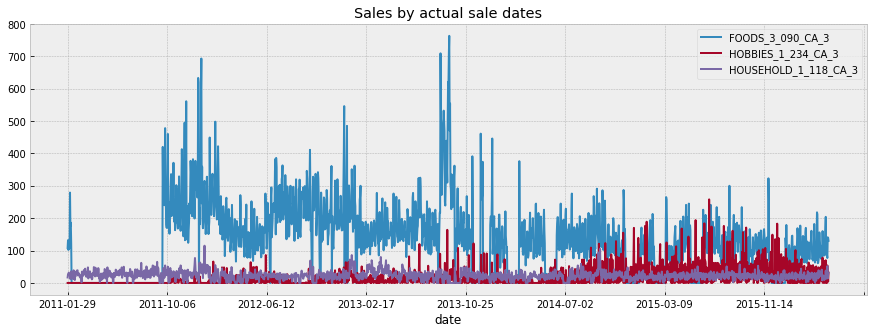

In [ ]:
example = sales_train_validation_df.loc[sales_train_validation_df['id']=='FOODS_3_090_CA_3_validation'][d_cols].T
example.rename(columns={8412:'FOODS_3_090_CA_3'}, inplace=True)
example = example.reset_index().rename(columns={'index':'d'})
example = example.merge(calendar_df, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle))

# Select more top selling examples
example2 = sales_train_validation_df.loc[sales_train_validation_df['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(calendar_df, how='left', validate='1:1')
example2.set_index('date')['HOBBIES_1_234_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle))

example3 = sales_train_validation_df.loc[sales_train_validation_df['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(calendar_df, how='left', validate='1:1')
example2 = example2.merge(calendar_df, how='left', validate='1:1')
example3.set_index('date')['HOUSEHOLD_1_118_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='Sales by actual sale dates')
plt.legend()
plt.show()

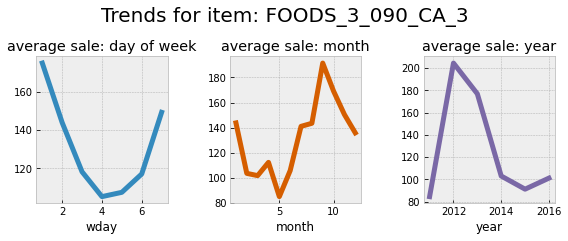

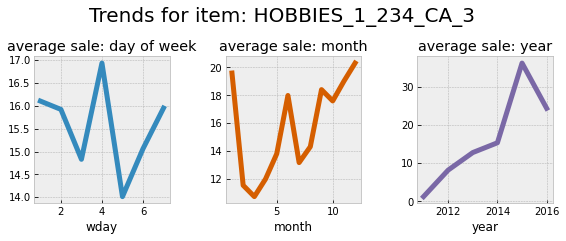

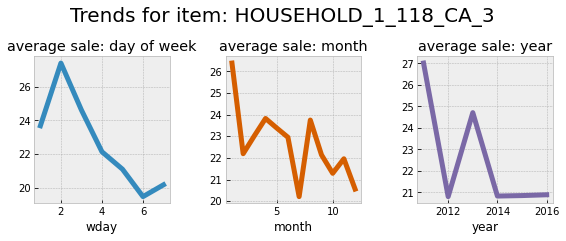

In [ ]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

In [ ]:
## Creating Date List

In [ ]:
#Create date index
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [ ]:
## Selecting One arbitrary time series

In [ ]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

#Set Dates as index
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


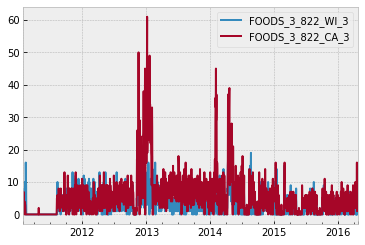

In [ ]:
DF_Sales[['FOODS_3_822_WI_3','FOODS_3_822_CA_3']].plot()

In [ ]:
## There is considerable variation between same product sales in different stores

In [ ]:
DF_Sales.columns.get_loc('FOODS_3_822_WI_3')

30484

In [ ]:
DF_Sales.columns.get_loc('HOBBIES_1_330_CA_1')

321

In [ ]:
##Plot the time series

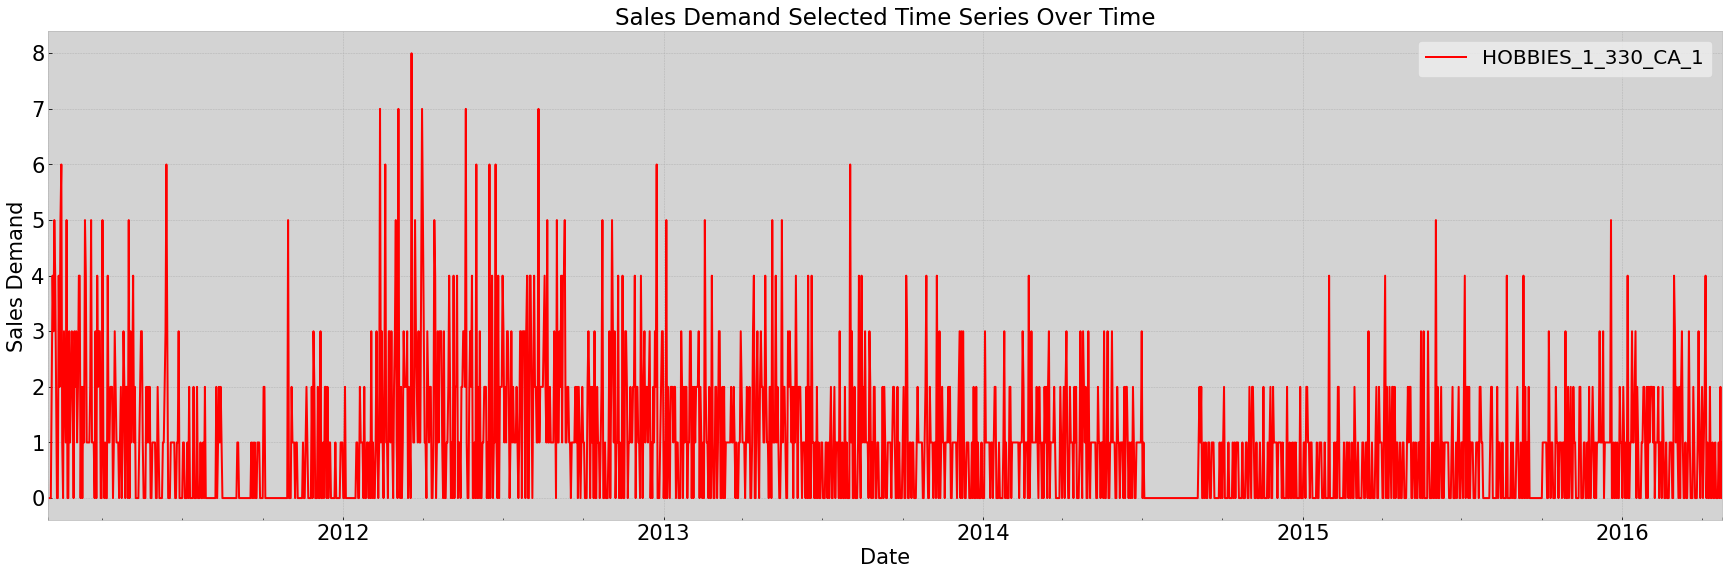

In [ ]:
#Select arbitrary index and plot the time series
index = 321
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [ ]:
#del calendar_df, sales_train_validation_df,DF_Sales
#gc.collect()

In [ ]:
###SEED ALL

In [ ]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

In [ ]:
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [ ]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1. ]
 [-1. ]
 [-1. ]
 [-1. ]
 [-0.5]]
[[-0.75]
 [-1.  ]
 [-0.5 ]
 [-1.  ]
 [-0.75]]


In [ ]:
train_data_normalized.shape

(1913, 1)

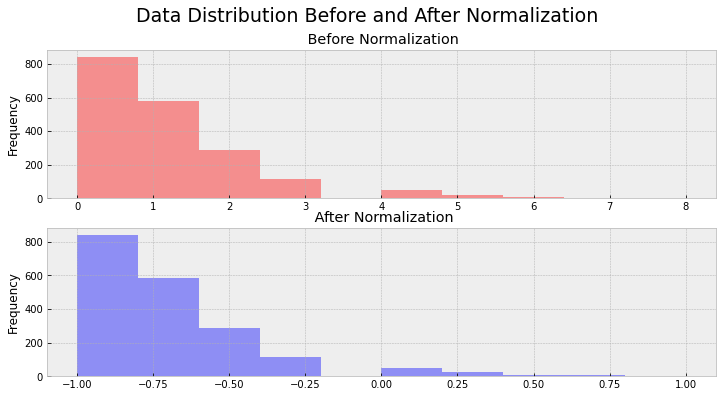

In [ ]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
pd.DataFrame(train_data_normalized).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')

In [ ]:
## Create Sequences 

In [ ]:
### This function creates a sliding window or sequences of 28 days and one day label ####
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
        
    return np.array(x),np.array(y)

In [ ]:
#train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1884, 28, 1)
(1884, 1)


In [ ]:
##Pytorch Tensors

In [ ]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 1])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 1])
test label shape is: torch.Size([622, 1])


In [ ]:
#Predict on Entire Data Set¶

In [ ]:
## Using multiple LSTM layers

In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

In [ ]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        

In [ ]:
num_epochs = 700
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 2

num_classes = 1

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    scheduler.step(loss)
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))


Epoch: 0, loss: 0.76082 valid loss:  0.11354 
Epoch: 50, loss: 0.09790 valid loss:  0.05314 
Epoch: 100, loss: 0.09285 valid loss:  0.05025 
Epoch: 150, loss: 0.09220 valid loss:  0.04979 
Epoch: 200, loss: 0.09194 valid loss:  0.04966 
Epoch: 250, loss: 0.09172 valid loss:  0.04965 
Epoch: 300, loss: 0.09171 valid loss:  0.04967 
Epoch: 350, loss: 0.09165 valid loss:  0.04968 
Epoch: 400, loss: 0.09099 valid loss:  0.04968 
Epoch: 450, loss: 0.09122 valid loss:  0.04969 
Epoch: 500, loss: 0.09135 valid loss:  0.04969 
Epoch: 550, loss: 0.09113 valid loss:  0.04969 
Epoch: 600, loss: 0.09156 valid loss:  0.04969 
Epoch: 650, loss: 0.09115 valid loss:  0.04969 


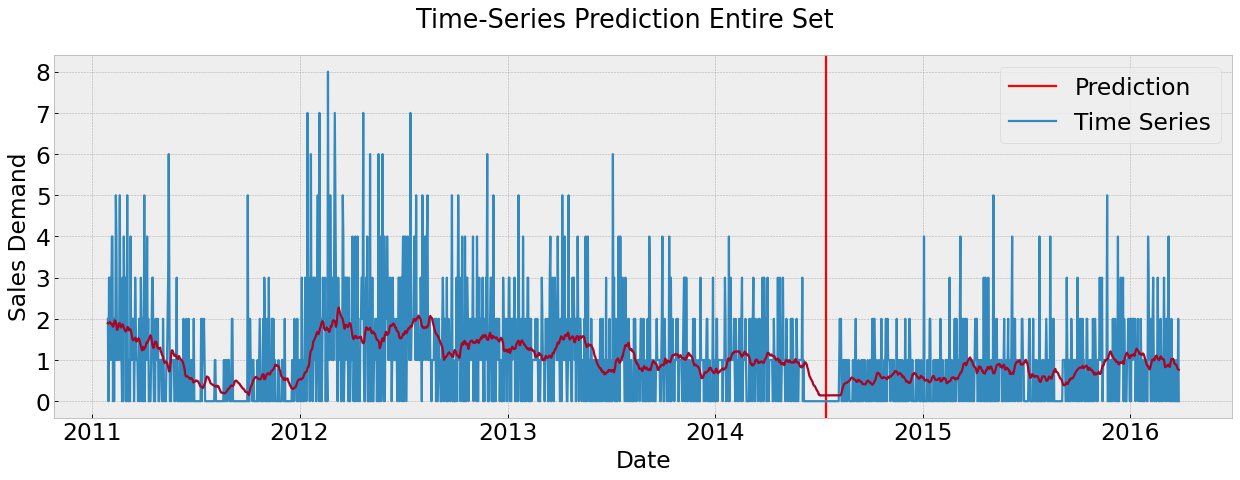

In [ ]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

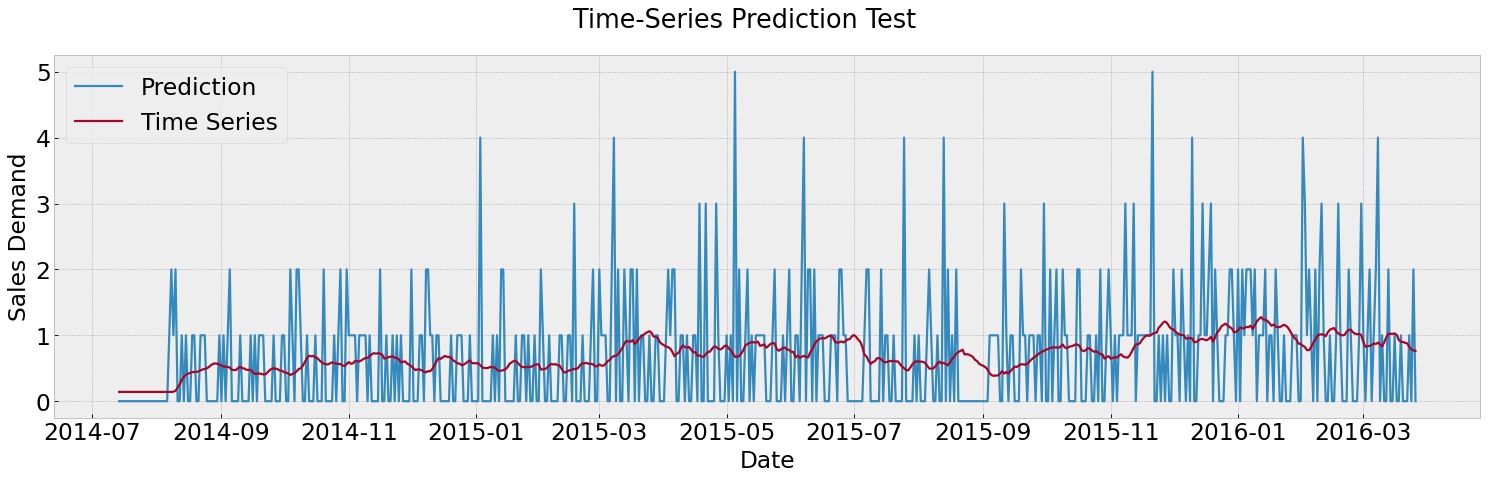

In [ ]:
#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [ ]:
##TEST RMSE

In [ ]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

0.8916637

In [ ]:
# Re-Use the Time Series we have selected earlier
DF = TS_selected
colnames = DF.columns
DF = DF.rename(columns={colnames[0]:'sales'})
DF.tail()

,sales
2016-04-20,1
2016-04-21,0
2016-04-22,2
2016-04-23,0
2016-04-24,1


In [ ]:
start_time = time.time()
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

Shifting: 1
Shifting: 7
Shifting: 14
Shifting: 28
Shifting: 365
0.00 min: Time for bulk shift


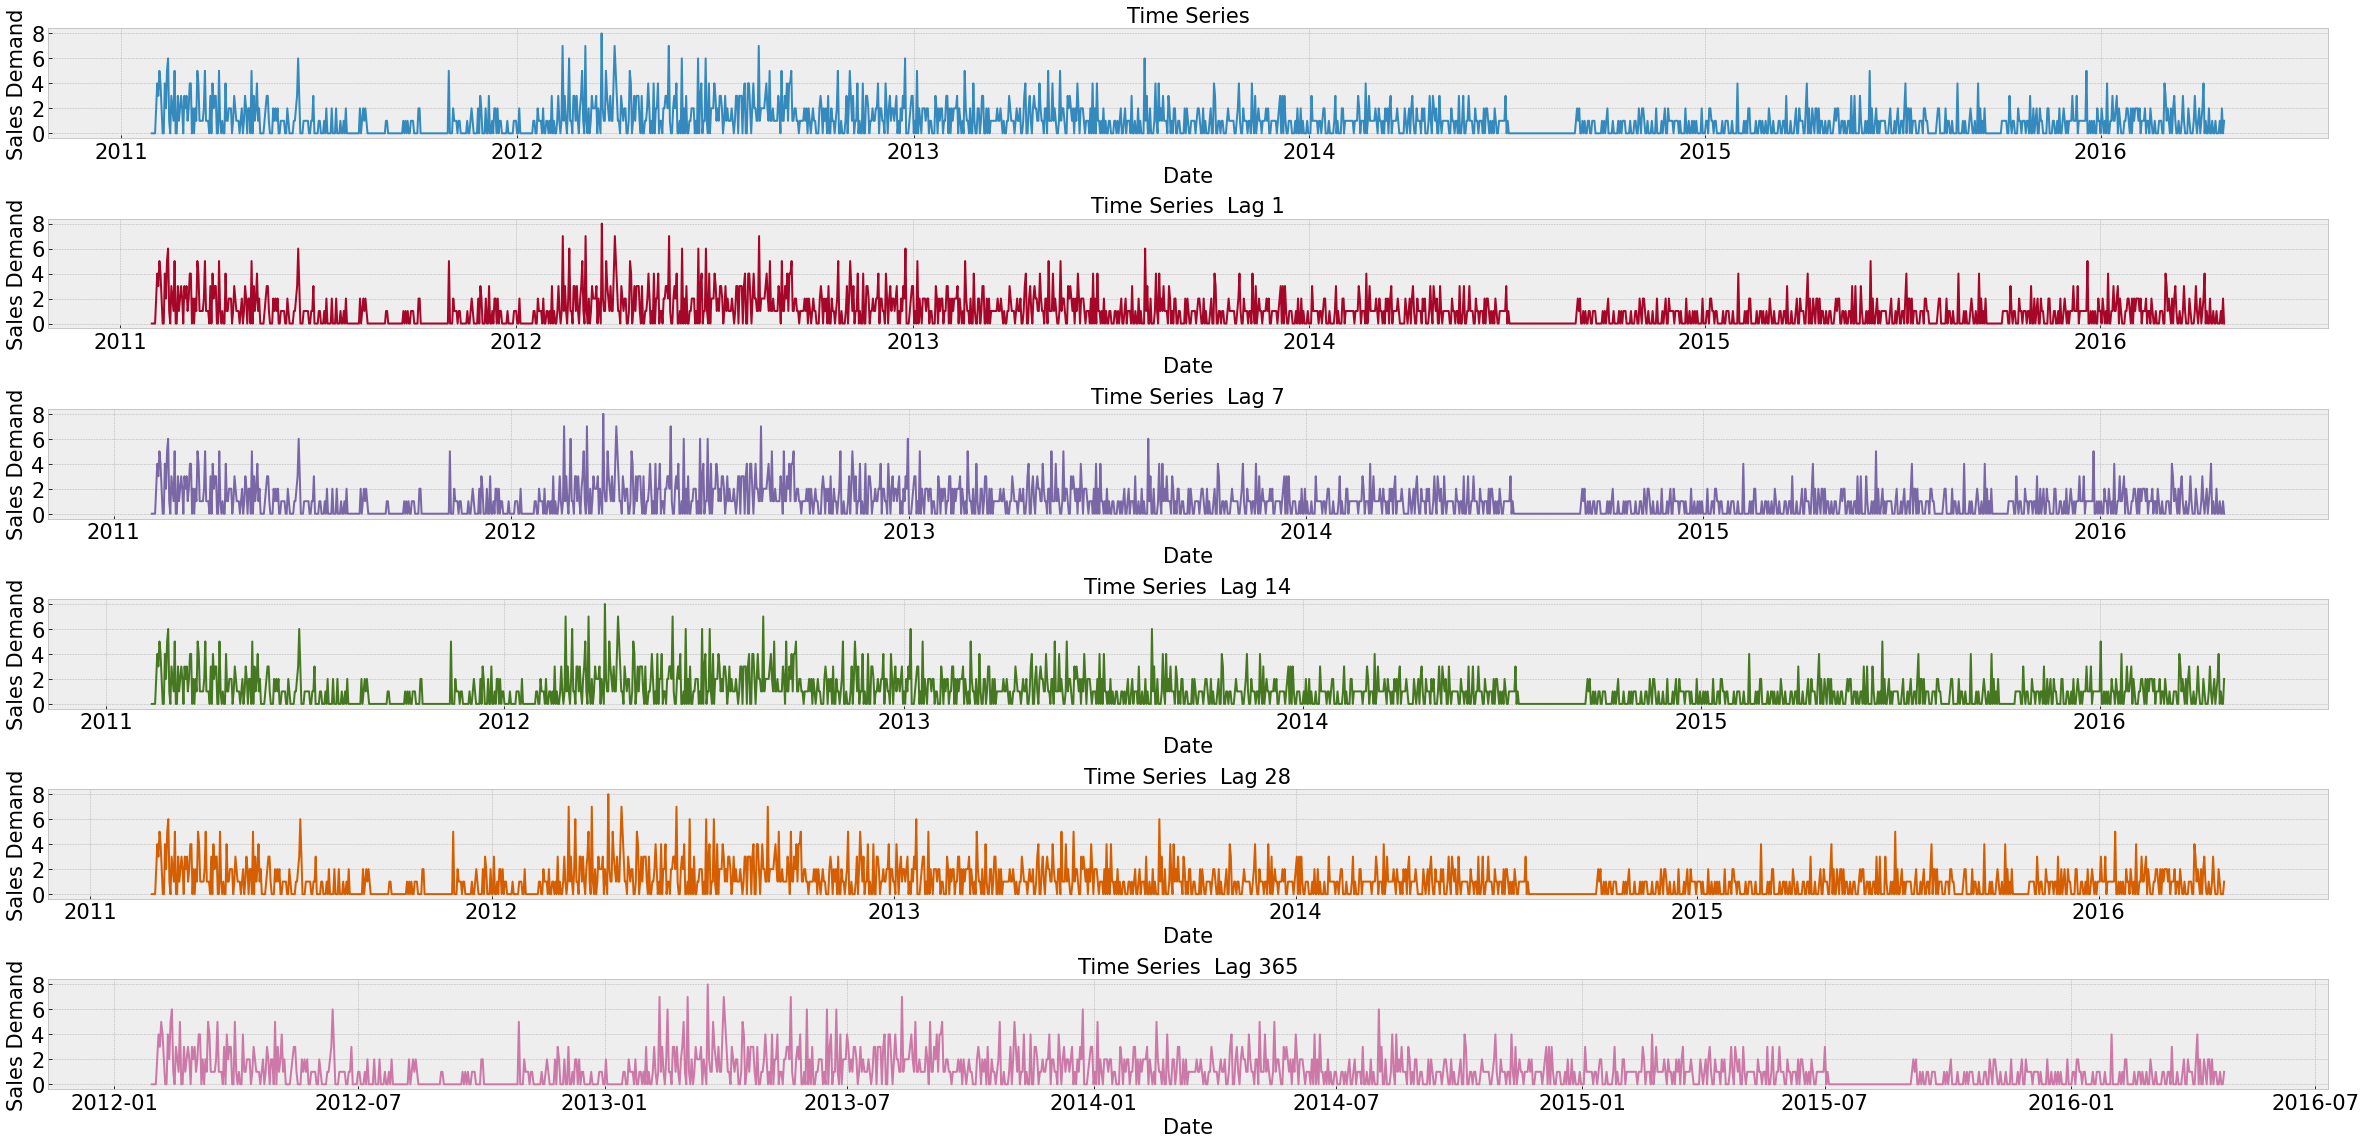

In [ ]:
 
DF = DF.set_index([dates_list])
Product = "Time Series"

################Create Plot ##############################################
fig, axs = plt.subplots(6, 1, figsize=(33, 16))
axs = axs.flatten()
ax_idx = 0

for i in (0,1,7,14,28,365):
    if i == 0:
        ax = DF['sales'].plot(fontsize = 21,
                     legend =False,
                     color=next(color_cycle),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product)

        ax_idx += 1
    else : 
        ax = DF[f'lag_{i}'].plot(fontsize = 21,
                     legend =False,
                     color=next(color_cycle),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product+f'  Lag {i}')

        ax_idx += 1

plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )

plt.tight_layout()
plt.show()

In [ ]:
## Rolling Windows

In [ ]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 60
Rolling period: 180
Rolling period: 365
0.04 min: Time for loop


,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-30,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-31,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-02,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
###The lags and rolling windows created Nan values When I tried to train with Nan values, the loss was also Nan Need further understanding, but for now, I will replace the Nan by zero

In [ ]:
DF = DF.replace('nan', np.nan).fillna(0)
DF.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-31,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-02,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
##Normalize

In [ ]:
DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
DF_normlized.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-01-30,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-01-31,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-02,-0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
DF_normlized = DF_normlized.reset_index()
DF_normlized = DF_normlized.rename(columns={'index':'date'})
DF_normlized.head()
DF_normlized['date'] = DF_normlized['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
DF_normlized = DF_normlized.merge(calendar_df[['date','weekday']],on='date')
DF_normlized.head()

,date,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365,weekday
0,2011-01-29,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Saturday
1,2011-01-30,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Sunday
2,2011-01-31,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Monday
3,2011-02-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Tuesday
4,2011-02-02,-0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Wednesday


In [ ]:
## Adding the embedded vectors 
DF_normlized['wd1'] =0
DF_normlized['wd2'] =0
DF_normlized['wd3'] =0
DF_normlized['wd4'] =0

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Sunday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Sunday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Sunday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Sunday']= 0.4 ,-0.3 ,0.6,0.1

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Monday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Monday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Monday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Monday']= 0.2 ,0.2 ,0.5,-0.3

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Tuesday'] ,DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Tuesday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Tuesday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Tuesday']= 0.1,-1.0,1.3,0.9

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Wednesday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Wednesday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Wednesday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Wednesday']= -0.6,0.5,1.2,0.7

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Thursday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Thursday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Thursday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Thursday']= 0.9,0.2,-0.1,0.6

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Friday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Friday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Friday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Friday']= 0.4,1.1,0.3,-1.5


DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Saturday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Saturday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Saturday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Saturday']= 0.3,-0.2,0.6,0.0

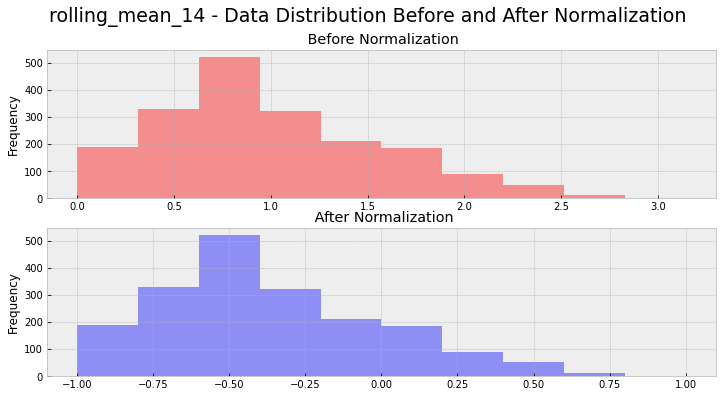

In [ ]:
fig, axs = plt.subplots(2)
 
fig.suptitle('rolling_mean_14 - Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(DF['rolling_mean_14']).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
pd.DataFrame(DF_normlized['rolling_mean_14']).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')

In [ ]:
##Multidimensional Sliding Window

In [ ]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
###  For Multiple features                                                            ####
def sliding_windows_mutli_features(data, seq_length):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        _x = data[i:(i+seq_length),:] ## 16 columns for features  
        _y = data[i+seq_length,0] ## column 0 contains the labbel
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y).reshape(-1,1)

In [ ]:
# Select only the features and the target for prediction  
data_with_features = DF_normlized[["sales","lag_7","lag_1","lag_28","lag_365","rolling_mean_7",\
"rolling_std_7","rolling_mean_14","rolling_std_14","rolling_mean_28","rolling_std_28","rolling_mean_60","rolling_std_60",'lag_28','wd1','wd2','wd3','wd4']].to_numpy()             

#data_with_features = DF_normlized['sales'].to_numpy().reshape(-1,1)
data_with_features.shape

(1913, 18)

In [ ]:
x , y = sliding_windows_mutli_features(data_with_features,seq_length=28)
print("X_data shape is",x.shape)
print("y_data shape is",y.shape)

X_data shape is (1884, 28, 18)
y_data shape is (1884, 1)


In [ ]:
##Pytorch Tensor

In [ ]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 18])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 18])
test label shape is: torch.Size([622, 1])


In [ ]:
##LSTM Model

In [ ]:
class LSTM3(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM3, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.2)
       
        
        
        self.fc1 = nn.Linear(hidden_size,256)
        self.bn1 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 128)
            
        self.bn2 = nn.BatchNorm1d(128,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp2 = nn.Dropout(0.2)
        self.fc3= nn.Linear(128, 1)
        self.relu = nn.ReLU()
       
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        
        x0 = self.fc1(final_state)
        x0 = self.bn1(x0)
        x0 = self.dp1(x0)
        x0 = self.relu(x0)
        
        x0 = self.fc2(x0)
        x0 = self.bn2(x0)
        x0 = self.dp2(x0)
        
        x0 = self.relu(x0)
        
        out = self.fc3(x0)
        #print(out.size())
        return out

In [ ]:
## Training

In [ ]:
num_epochs = 500
learning_rate = 1e-3
input_size = 18
hidden_size = 512
num_layers = 1
num_classes = 1

best_val_loss = 100

lstm = LSTM3(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=50, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    #scheduler.step()
    
    if vall_loss.cpu().item() < best_val_loss:
         torch.save(lstm.state_dict(), 'best_model.pt')
         print("saved best model epoch:",epoch,"val loss is:",vall_loss.cpu().item())
         best_val_loss = vall_loss.cpu().item()
        
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))


saved best model epoch: 0 val loss is: 0.6643744707107544
Epoch: 0, loss: 0.56507 valid loss:  0.66437 
saved best model epoch: 1 val loss is: 0.6541423797607422
saved best model epoch: 2 val loss is: 0.6440388560295105
saved best model epoch: 3 val loss is: 0.6340624094009399
saved best model epoch: 4 val loss is: 0.6240598559379578
saved best model epoch: 5 val loss is: 0.6140932440757751
saved best model epoch: 6 val loss is: 0.6041256785392761
saved best model epoch: 7 val loss is: 0.5939475893974304
saved best model epoch: 8 val loss is: 0.5837278366088867
saved best model epoch: 9 val loss is: 0.5741769671440125
saved best model epoch: 10 val loss is: 0.5642634034156799
saved best model epoch: 11 val loss is: 0.554063618183136
saved best model epoch: 12 val loss is: 0.5453909039497375
saved best model epoch: 13 val loss is: 0.5357625484466553
saved best model epoch: 14 val loss is: 0.5226132273674011
saved best model epoch: 15 val loss is: 0.5117952227592468
saved best model epoc

In [ ]:
##Predict

(1884, 1)
(1884, 1)


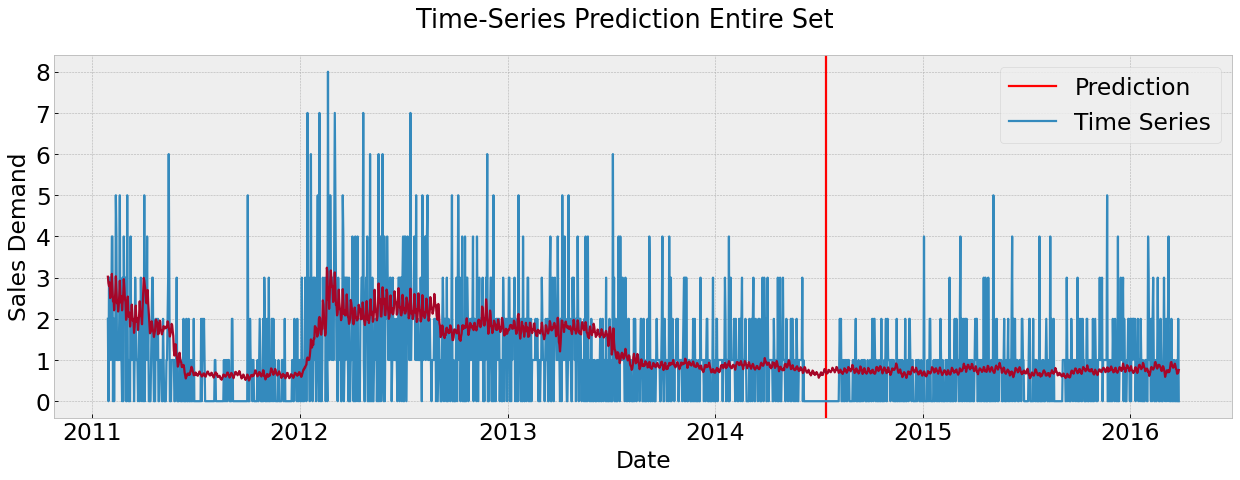

In [ ]:
######Prediction###############
lstm.load_state_dict(torch.load('best_model.pt'))

lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()
print(data_predict.shape)
print(dataY_plot.shape)


## Inverse Normalize 
data_predict = y_scaler.inverse_transform(data_predict)
dataY_plot = y_scaler.inverse_transform(dataY_plot.reshape(-1, 1))

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


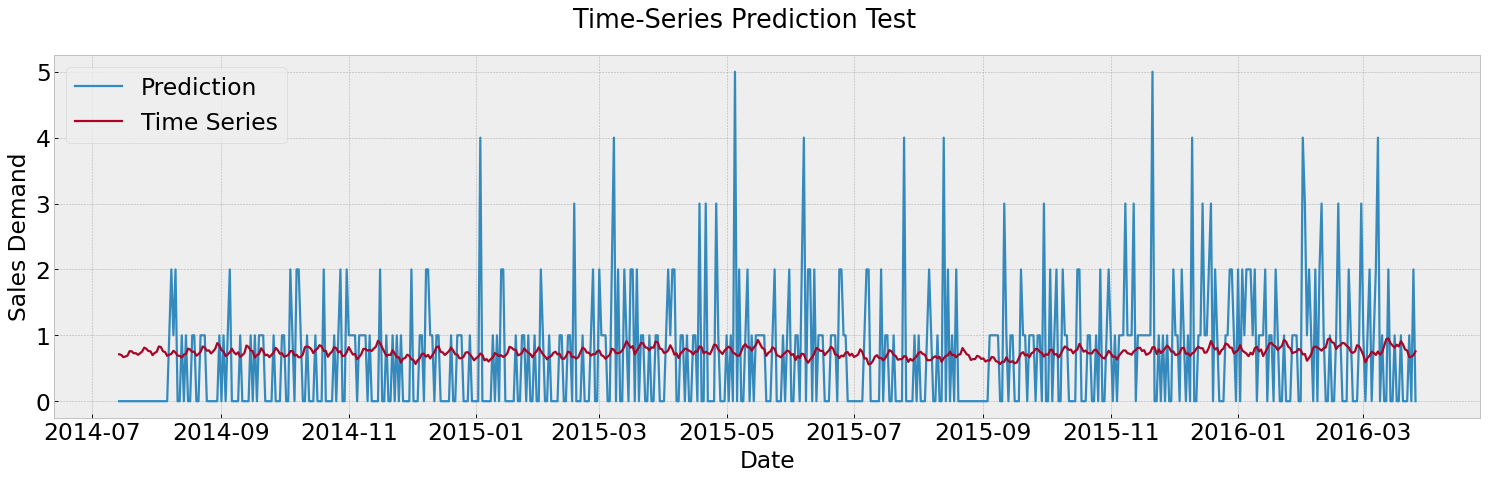

In [ ]:
#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [ ]:
##RMSE Test

In [ ]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

0.89776033

In [ ]:

### Sequence to Sequence Modelling

In [ ]:
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


In [ ]:
DF_Sales.columns[321]

'HOBBIES_1_330_CA_1'

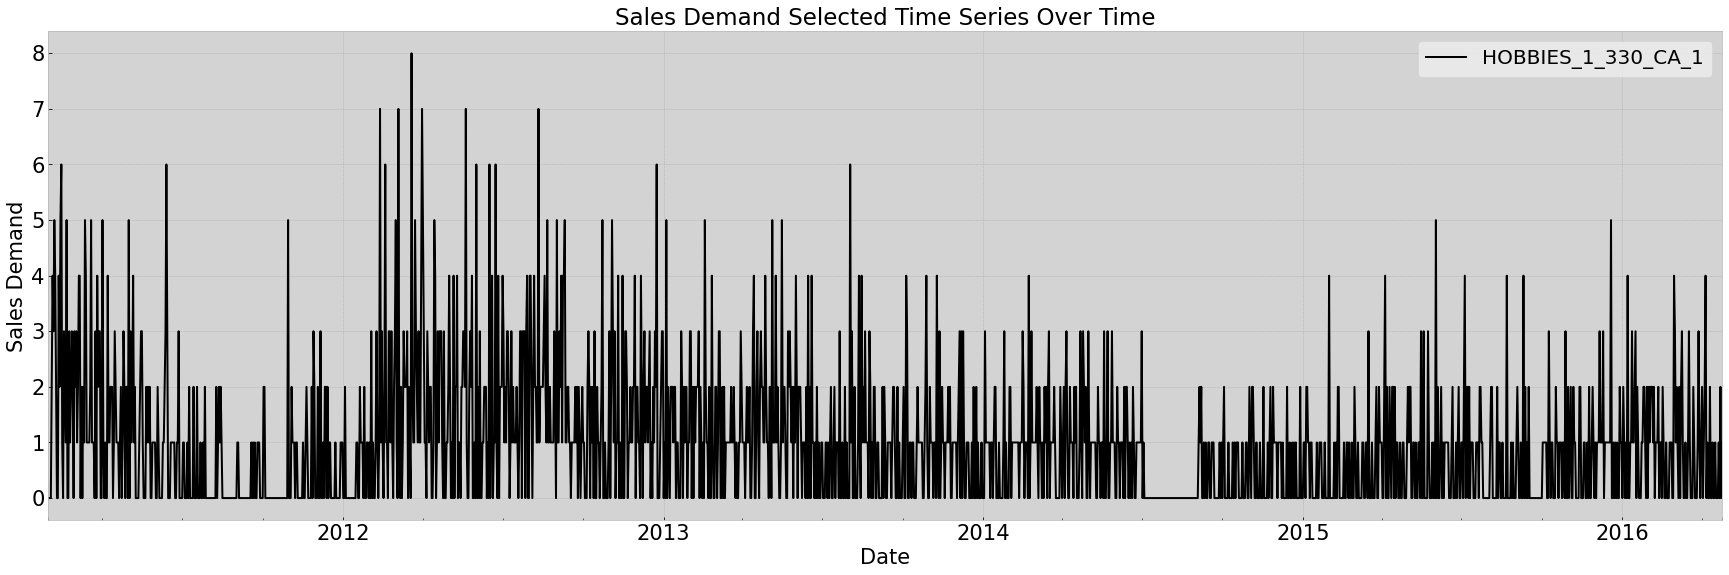

In [ ]:
#Select arbitrary index and plot the time series
index = 321
y = pd.DataFrame(DF_Sales.iloc[:,index])
TS_selected = y 
y = pd.DataFrame(y).set_index([dates_list])
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='black')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [ ]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

In [ ]:
train_size = int((len(TS_selected)-28) * 0.67)
valid_size = (len(TS_selected)-28)- train_size
print("train size is:",train_size)
print("validation size is:",valid_size)

train size is: 1262
validation size is: 623


In [ ]:
train_data = TS_selected.iloc[0:train_size,:]
valid_data = TS_selected.iloc[train_size:train_size+valid_size,:]
print("train data shape is:",train_data.shape)
print("validation data shape is:",valid_data.shape)

train data shape is: (1262, 1)
validation data shape is: (623, 1)


In [ ]:
##Difference Transformer

In [ ]:
## Simple Difference transform  --> X(t)' = X(t) - X(t-7)
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

np_tarin_data = train_data.iloc[:,0]
interval = 7 
transformed_train = difference(np_tarin_data, interval)

np_valid_data = valid_data.iloc[:,0]
interval = 7 
transformed_valid = difference(np_valid_data, interval)

train_data = np.array(transformed_train).reshape(len(transformed_train),1)
valid_data = np.array(transformed_valid).reshape(len(transformed_valid),1)

In [ ]:
train_data.shape

(1255, 1)

In [ ]:
valid_data.shape

(616, 1)

In [ ]:
##Normlize/Scale Data 

In [ ]:
scaler = MinMaxScaler((-1,1)).fit(train_data)
#scaler = StandardScaler().fit(train_data)
train_data_std = scaler.transform(train_data)
valid_data_std = scaler.transform(valid_data)

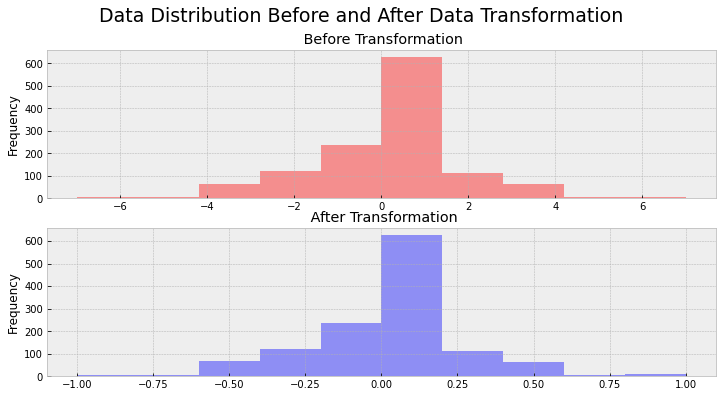

In [ ]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Data Transformation   ',fontsize = 19)
pd.DataFrame(train_data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Transformation',color ='red') 
pd.DataFrame(train_data_std).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Transformation'\
                                         ,color = 'blue')
   

In [ ]:
##We wil use a sliding window of 90 days Our target(labels) is 28 days

In [ ]:
###  This function creates a sliding window or sequences of seq_length days and labels_length  days label ####
def sliding_windows(data, seq_length,labels_length):
    x = []
    y = []

    for i in range(len(data)-(seq_length+labels_length)):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+labels_length)]
        x.append(_x)
        y.append(_y)

    return x,y

In [ ]:
seq_length = 90
labels_length =28
train_X, train_y = sliding_windows(train_data_std, seq_length,labels_length)
print("train X  has:", len(train_X) , "series")
print("train labels  has:", len(train_y) , "series")
valid_X, valid_y = sliding_windows(valid_data_std, seq_length,labels_length)
print("validiation  X  has:", len(valid_X) , "series")
print("Validiation  labels  has:" ,len(valid_y) , "series")

train X  has: 1137 series
train labels  has: 1137 series
validiation  X  has: 498 series
Validiation  labels  has: 498 series


(-1.0, 1.0)

<Figure size 1080x1224 with 0 Axes>

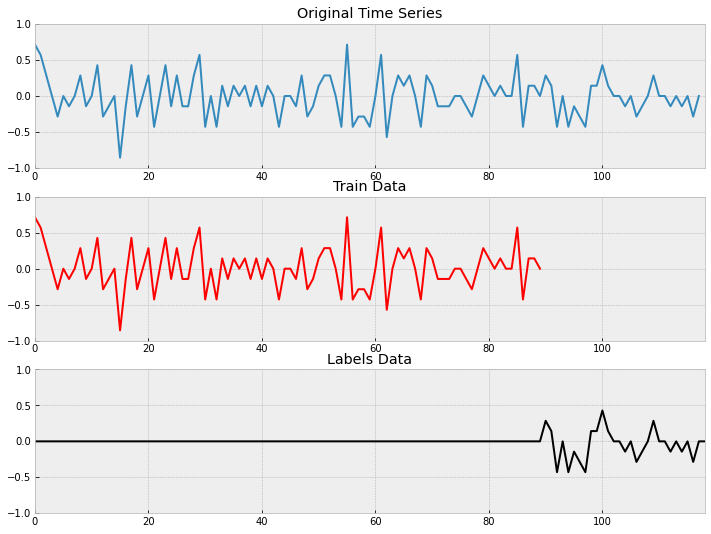

In [ ]:
plt.figure(figsize=(15,17))
fig, axs =plt.subplots(3,figsize=(12,9))

axs[0].plot(train_data_std[0:seq_length+labels_length])
axs[0].title.set_text('Original Time Series')
axs[0].set_xlim(0,seq_length+labels_length)
axs[0].set_ylim(-1,1)
axs[1].plot(train_X[0].flatten(),color="red")
axs[1].title.set_text('Train Data')
axs[1].set_xlim(0,seq_length+labels_length)
axs[1].set_ylim(-1,1)
axs[2].plot(np.pad(train_y[0].flatten(),seq_length),color='black')
axs[2].title.set_text('Labels Data')
axs[2].set_xlim(0,seq_length+labels_length)
axs[2].set_ylim(-1,1)

In [ ]:
##Pytorch Tensors

In [ ]:
trainX = Variable(torch.Tensor(train_X))
trainy = Variable(torch.Tensor(train_y))

validX = Variable(torch.Tensor(valid_X))
validy= Variable(torch.Tensor(valid_y))

print ("trainX shape is:",trainX.size())
print ("trainy shape is:",trainy.size())
print ("validX shape is:",validX.size())
print ("validy shape is:",validy.size())

trainX shape is: torch.Size([1137, 90, 1])
trainy shape is: torch.Size([1137, 28, 1])
validX shape is: torch.Size([498, 90, 1])
validy shape is: torch.Size([498, 28, 1])


In [ ]:
##Building the Seq2Seq Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        #return hidden_n.reshape((self.n_features, self.embedding_dim))
        return x, hidden , cell 

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim ) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
       
        hidden = hidden[2:3,:,:]
        
        #print("hidden size is",hidden.size())
        
        
        
        #repeat decoder hidden state src_len times
        #hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        hidden = hidden.repeat(1, src_len, 1)
     
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #print("encode_outputs size after permute is:",encoder_outputs.size())
        
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        
        return F.softmax(attention, dim=1)


In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=1,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
       
       
        x = x.reshape((1,1,1))
        
        
     

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n

In [ ]:
class AttentionDecoder(nn.Module):
    def __init__(self, seq_len,attention, input_dim=64, n_features=1,encoder_hidden_state = 512):
        super(AttentionDecoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        self.attention = attention 
        
        self.rnn1 = nn.LSTM(
          #input_size=1,
          input_size= encoder_hidden_state + 1,  # Encoder Hidden State + One Previous input
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim * 2 , n_features)

    def forward(self, x,input_hidden,input_cell,encoder_outputs):
       
        a = self.attention(input_hidden, encoder_outputs)
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
      
        
        weighted = torch.bmm(a, encoder_outputs)
        
        
     
        x = x.reshape((1,1,1))
       
        
        
        rnn_input = torch.cat((x, weighted), dim = 2)
       

        #x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
        x, (hidden_n, cell_n) = self.rnn1(rnn_input,(input_hidden,input_cell))
        
        output = x.squeeze(0)
        weighted = weighted.squeeze(0)
        
        x = self.output_layer(torch.cat((output, weighted), dim = 1))
        return x, hidden_n, cell_n
    

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 28):
        super(Seq2Seq, self).__init__()

        
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.attention = Attention(512,512)
        self.output_length = output_length
        self.decoder = AttentionDecoder(seq_len, self.attention, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y):
        
        encoder_output,hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        prev_output = prev_y
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
        
            prev_x,prev_hidden,prev_cell = self.decoder(prev_output,hidden,cell,encoder_output)
            hidden,cell = prev_hidden,prev_cell
            prev_output = prev_x
            
            targets_ta.append(prev_x.reshape(1))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

In [ ]:
n_features = 1
model = Seq2Seq(seq_length, n_features, 512)
model = model.to(device)

In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (decoder): AttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn1): LSTM(513, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (decoder): AttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn1): LSTM(513, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3,weight_decay=1e-5)
criterion = torch.nn.MSELoss().to(device) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [ ]:
def train_model(model, TrainX,Trainy,ValidX,Validy,seq_length, n_epochs):
  
    history = dict(train=[], val=[])

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    mb = master_bar(range(1, n_epochs + 1))

    for epoch in mb:
        model = model.train()

        train_losses = []
        for i in progress_bar(range(TrainX.size()[0]),parent=mb):
            seq_inp = TrainX[i,:,:].to(device)
            seq_true = Trainy[i,:,:].to(device)
           
            optimizer.zero_grad()

            
            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
            
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in progress_bar(range(validX.size()[0]),parent=mb):
                seq_inp = ValidX[i,:,:].to(device)
                seq_true = Validy[i,:,:].to(device)
        
                seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
               

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        scheduler.step()
    #model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  trainX,trainy,
  validX,validy,
  seq_length,
  n_epochs=10, ## Training only on 30 epochs to save GPU time 
    
)

saved best model epoch: 1 val loss is: 0.035889951824528504
Epoch 1: train loss 0.10755198878558023 val loss 0.035889951824528504
Epoch 2: train loss 0.05656656173935116 val loss 0.03727636144619929
Epoch 3: train loss 0.11215646755115745 val loss 0.038034822563659476
Epoch 4: train loss 0.06336597306797201 val loss 0.03621540825634477
Epoch 5: train loss 0.05672631564688531 val loss 0.036210628845411014
Epoch 6: train loss 0.05659757479337243 val loss 0.037231434007590436
saved best model epoch: 7 val loss is: 0.03564942994502833
Epoch 7: train loss 0.05667887980498459 val loss 0.03564942994502833
Epoch 8: train loss 0.057592083163896905 val loss 0.036123003186022185
Epoch 9: train loss 0.06035946149963856 val loss 0.03629893365963156
Epoch 10: train loss 0.13940975402884034 val loss 0.036032640984857894


In [ ]:
##Predict

In [ ]:
TestX = np.array(TS_selected.iloc[-118:-28:,:])
Testy = np.array(TS_selected.iloc[-28:,:])
TestX = Variable(torch.Tensor(TestX))

In [ ]:
TestX_Diff = difference(TestX, interval)
TestX_Diff_Norm = scaler.transform(np.array(TestX_Diff).reshape(len(TestX_Diff),1))

In [ ]:
######Prediction###############
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    seq_inp = TestX.to(device)
    
        
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])

In [ ]:
## Inverse Normalise

In [ ]:
data_predict = scaler.inverse_transform(seq_pred.cpu().numpy())
labels = Testy

In [ ]:
## Inverse Difference transform

In [ ]:
orignal_data = np.array(TS_selected.iloc[-118:-28:,:]).flatten()
pred = data_predict.flatten()
orig_pred = np.concatenate([orignal_data,pred])

In [ ]:
time_diff = 7 
inv_pred = np.zeros((28))
for  index in range(28):
    inv_pred[index] = orig_pred[90+index]+ orig_pred[90+index-7]
    orig_pred[90+index] = inv_pred[index]

In [ ]:
data_predict= np.array(inv_pred)
data_predict = np.where(data_predict<0,0,data_predict)

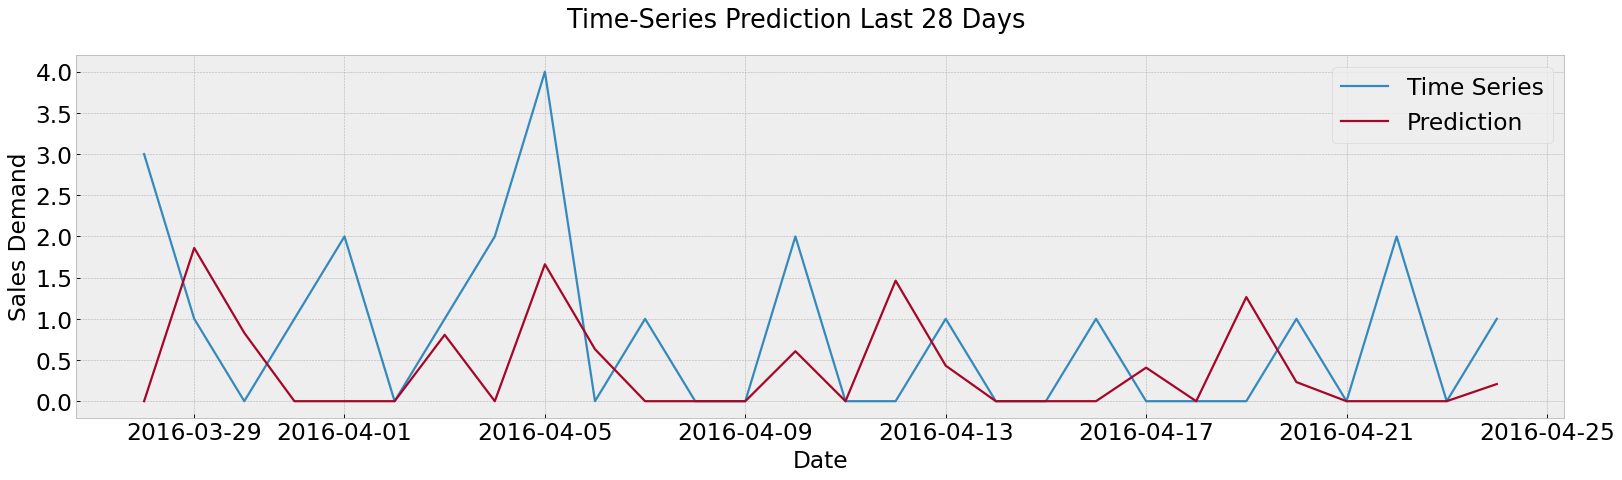

In [ ]:
## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[-28:]])
df_labels = pd.DataFrame(labels)
df_labels = df_labels.set_index([dates_list[-28:]])

# Plot 
figure(num=None, figsize=(24, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction'],fontsize = 21)
plt.suptitle('Time-Series Prediction Last 28 Days',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [ ]:
##RMSE

In [ ]:
np.sqrt(((data_predict - labels) ** 2).mean())

1.2596563754456807

In [ ]:
##Adding Features

In [ ]:
DF = TS_selected
colnames = DF.columns
DF = DF.rename(columns={colnames[0]:'sales'})
DF.tail()

,sales
2016-04-20,1
2016-04-21,0
2016-04-22,2
2016-04-23,0
2016-04-24,1


In [ ]:
## Simple Difference transform  --> X(t)' = X(t) - X(t-7)

def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

transformed_data = difference(DF['sales'], interval)
DF = DF.iloc[7:,:]
DF['orig_sales'] = DF['sales']
DF['sales'] = transformed_data
DF.shape

(1906, 2)

In [ ]:
start_time = time.time()
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

Shifting: 1
Shifting: 7
Shifting: 14
Shifting: 28
Shifting: 365
0.00 min: Time for bulk shift


In [ ]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 60
Rolling period: 180
Rolling period: 365
0.01 min: Time for loop


,sales,orig_sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-02-05,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-06,4,4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-07,2,2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-08,0,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-09,-2,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
DF = DF.replace('nan', np.nan).fillna(0)
DF.head()

,sales,orig_sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-02-05,5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-06,4,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-07,2,2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-08,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-09,-2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
##Normalize
DF = DF.drop('orig_sales',1)
DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
   

DF_normlized.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-02-05,0.714286,0.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-06,0.571429,0.714286,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-07,0.285714,0.571429,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-08,0.000000,0.285714,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-09,-0.285714,0.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
##Split Data

In [ ]:
train_size = int((DF_normlized.shape[0]-28) * 0.67)
valid_size = (DF_normlized.shape[0]-28)- train_size
print("train size is:",train_size)
print("validation size is:",valid_size)
train_data = DF_normlized.iloc[0:train_size,:]
valid_data = DF_normlized.iloc[train_size:train_size+valid_size,:]
print("train data shape is:",train_data.shape)
print("validation data shape is:",valid_data.shape)

train size is: 1258
validation size is: 620
train data shape is: (1258, 18)
validation data shape is: (620, 18)


In [ ]:
###  This function creates a sliding window or sequences of seq_length days and labels_length  days label ####
def sliding_windows(data, seq_length,labels_length):
    x = []
    y = []
    z = []

    for i in range(len(data)-(seq_length+labels_length)):
        _x = data.iloc[i:(i+seq_length),:]
        _y = data.iloc[(i+seq_length):(i+seq_length+labels_length),0:1]
        _z  = data.iloc[(i+seq_length):(i+seq_length+labels_length),1:]
        x.append(np.array(_x))
        y.append(np.array(_y))
        z.append(np.array(_z))

    return x,y,z

In [ ]:
seq_length = 90
labels_length =28
train_X, train_y,train_features = sliding_windows(train_data, seq_length,labels_length)
print("train X  has:", len(train_X) , "series")
print("train labels  has:", len(train_y) , "series")
valid_X, valid_y,valid_features = sliding_windows(valid_data, seq_length,labels_length)
print("validiation  X  has:", len(valid_X) , "series")
print("Validiation  labels  has:" ,len(valid_y) , "series")

train X  has: 1140 series
train labels  has: 1140 series
validiation  X  has: 502 series
Validiation  labels  has: 502 series


In [ ]:
##Pytorch Tensors

In [ ]:
trainX = Variable(torch.Tensor(train_X))
trainy = Variable(torch.Tensor(train_y))
train_features = Variable(torch.Tensor(train_features))
validX = Variable(torch.Tensor(valid_X))
validy= Variable(torch.Tensor(valid_y))
valid_features = Variable(torch.Tensor(valid_features))


print ("trainX shape is:",trainX.size())
print ("trainy shape is:",trainy.size())
print ("train features  shape is:",train_features.size())
print ("validX shape is:",validX.size())
print ("validy shape is:",validy.size())
print ("valid features  shape is:",valid_features.size())

trainX shape is: torch.Size([1140, 90, 18])
trainy shape is: torch.Size([1140, 28, 1])
train features  shape is: torch.Size([1140, 28, 17])
validX shape is: torch.Size([502, 90, 18])
validy shape is: torch.Size([502, 28, 1])
valid features  shape is: torch.Size([502, 28, 17])


In [ ]:
##Sequence to Sequence Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        #return hidden_n.reshape((self.n_features, self.embedding_dim))
        return hidden , cell 


In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
       
       
        x = x.reshape((1,1,self.n_features ))
        #print("decode input",x.size())
             

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n


In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 28):
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.n_features = n_features
        self.output_length = output_length
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y,features):
        
       
        hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        dec_input = prev_y
        
        
        
       #dec_input = torch.cat([prev_output, curr_features], dim=1) 
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
            
          
            prev_x,prev_hidden,prev_cell = self.decoder(dec_input,hidden,cell)
            hidden,cell = prev_hidden,prev_cell
            
            prev_x = prev_x[:,:,0:1]
            #print("preve x shape is:",prev_x.size())
            #print("features shape is:",features[out_days+1].size())
            
            if out_days+1 < self.output_length :
                dec_input = torch.cat([prev_x,features[out_days+1].reshape(1,1,17)], dim=2) 
            
            targets_ta.append(prev_x.reshape(1))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

In [ ]:
n_features = trainX.shape[2]
model = Seq2Seq(seq_length, n_features, 512)
model = model.to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(18, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (decoder): Decoder(
    (rnn1): LSTM(18, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=512, out_features=18, bias=True)
  )
)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(18, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (decoder): Decoder(
    (rnn1): LSTM(18, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=512, out_features=18, bias=True)
  )
)

In [ ]:
def train_model(model, TrainX,Trainy,ValidX,Validy,seq_length, n_epochs):
  
    history = dict(train=[], val=[])

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    mb = master_bar(range(1, n_epochs + 1))

    for epoch in mb:
        model = model.train()

        train_losses = []
        for i in progress_bar(range(TrainX.size()[0]),parent=mb):
            seq_inp = TrainX[i,:,:].to(device)
            seq_true = Trainy[i,:,:].to(device)
            features = train_features[i,:,:].to(device)
           
            optimizer.zero_grad()

            
            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
            
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in progress_bar(range(validX.size()[0]),parent=mb):
                seq_inp = ValidX[i,:,:].to(device)
                seq_true = Validy[i,:,:].to(device)
                features = valid_features[i,:,:].to(device)
        
                seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
               

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model_n_features.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        scheduler.step(val_loss)
    #model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2,weight_decay=1e-5)
criterion = torch.nn.MSELoss().to(device) 
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [ ]:
model, history = train_model(
  model,
  trainX,trainy,
  validX,validy,
  seq_length,
  n_epochs=10, #Train for few epochs as illustration, 
    
)

saved best model epoch: 1 val loss is: 0.03683919160148181
Epoch 1: train loss 0.1249716726605568 val loss 0.03683919160148181
Epoch 2: train loss 0.0686954145850777 val loss 0.03959147266828385
saved best model epoch: 3 val loss is: 0.036002906343613965
Epoch 3: train loss 0.06862776331897628 val loss 0.036002906343613965
Epoch 4: train loss 0.05776126791902801 val loss 0.039001716382475016
saved best model epoch: 5 val loss is: 0.03559776369586171
Epoch 5: train loss 0.05875332276010069 val loss 0.03559776369586171
Epoch 6: train loss 0.062067789990422235 val loss 0.03813178990911915
Epoch 7: train loss 0.4443766259057284 val loss 0.05102370355456355
saved best model epoch: 8 val loss is: 0.035563167524097335
Epoch 8: train loss 0.06730896959514275 val loss 0.035563167524097335
Epoch 9: train loss 0.06327602031166878 val loss 0.03682897912998836
saved best model epoch: 10 val loss is: 0.035373432995877654
Epoch 10: train loss 0.06093920282365983 val loss 0.035373432995877654


In [ ]:
##Predict

In [ ]:
TestX = np.array(TS_selected.iloc[-700:-28:,:]).flatten()
Testy = np.array(TS_selected.iloc[-28:,:])


TestX.shape

(672,)

In [ ]:
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

transformed_data = difference(TestX, interval)
DF = pd.DataFrame()
DF['sales'] = transformed_data
DF['orig_sales'] = TestX[7:]
DF.head(10)

,sales,orig_sales
0,-1,0
1,1,2
2,-2,1
3,0,1
4,-1,0
5,0,1
6,1,1
7,1,1
8,-2,0
9,1,2


In [ ]:
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

Shifting: 1
Shifting: 7
Shifting: 14
Shifting: 28
Shifting: 365
10.32 min: Time for bulk shift


In [ ]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 60
Rolling period: 180
Rolling period: 365
10.32 min: Time for loop


,sales,orig_sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
0,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#DF = DF.drop('orig_sales', 1)


DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
DF_normlized = DF_normlized.iloc[-90:,:]
TestX = Variable(torch.Tensor(np.array(DF_normlized)))

In [ ]:
######Prediction###############
model.load_state_dict(torch.load('/content/best_model_n_features.pt'))
model.eval()

with torch.no_grad():
    seq_inp = TestX.to(device)
    
        
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],seq_inp[:,1:])
          

In [ ]:
data_predict = y_scaler.inverse_transform(seq_pred.cpu().numpy())
labels = Testy

In [ ]:
orignal_data = np.array(TS_selected.iloc[-118:-28:,:]).flatten()
pred = data_predict.flatten()
orig_pred = np.concatenate([orignal_data,pred])

In [ ]:
time_diff = 7 
inv_pred = np.zeros((28))
for  index in range(28):
    inv_pred[index] = orig_pred[90+index]+ orig_pred[90+index-7]
    orig_pred[90+index] = inv_pred[index]

In [ ]:
data_predict= np.array(inv_pred)
#data_predict = np.where(data_predict<0,0,data_predict)

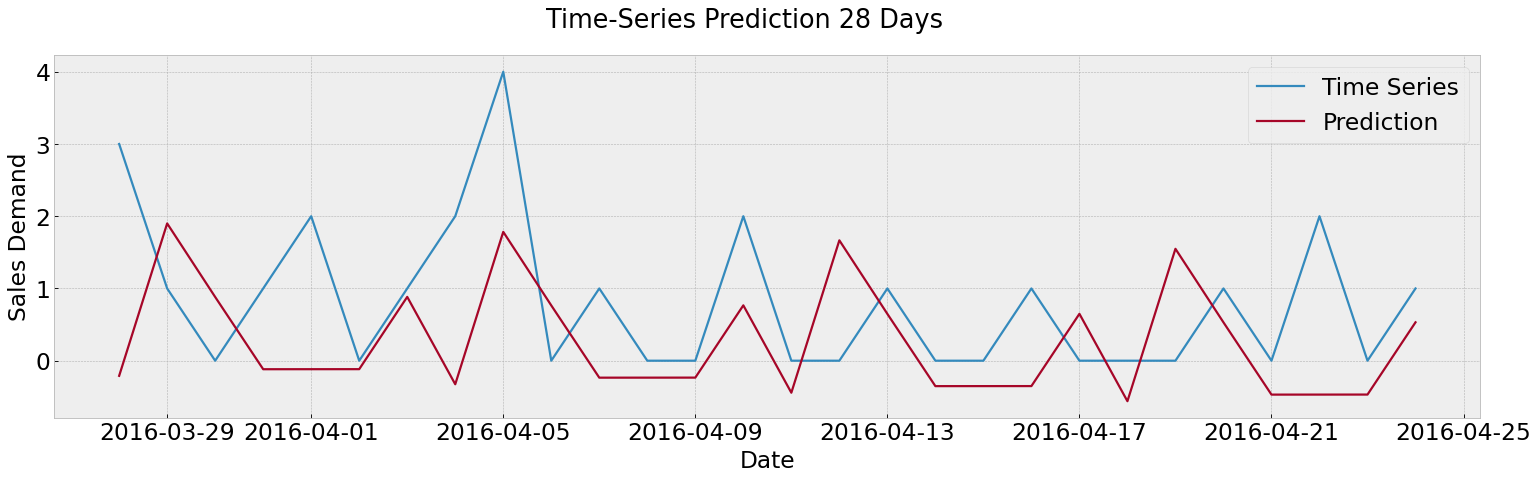

In [ ]:
## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[-28:]])
df_labels = pd.DataFrame(labels)
df_labels = df_labels.set_index([dates_list[-28:]])

# Plot 
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction'],fontsize = 21)
plt.suptitle('Time-Series Prediction 28 Days',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [ ]:
##RMSE

In [ ]:
np.sqrt(((data_predict - labels) ** 2).mean())

1.397493774713696